In [1]:
# установка pycuda
! pip install pycuda

In [13]:
# импорт библиотек, необходимых для работы

import numpy as np
np.random.seed(0) 

import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import time
import cv2

# т.к. колаб не отображет cv2.imshow, то использую эту функцию для проверки
from google.colab.patches import cv2_imshow

In [43]:
# CPU функция
def bilateral_filtering_cpu(im, sigma_r, sigma_d):
    result = np.zeros((im.shape[0], im.shape[1]))
    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            c, s = 0, 0
            for k in range(i-1, i+2):
                for l in range(j-1, j+2):
                    g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
                    r = np.exp(-(im[k, l] - im[i, j]) ** 2 / sigma_r ** 2)
                    c += g*r 
                    s +=   g*r*im[k, l]
            result[i, j] = s / c
    return result


# GPU функция
mod = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void bilateral_filtering_gpu(unsigned int* result, const int M, const int N, const float sigma_d, const float sigma_r)
{   
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;
    if ((i < M) && (j < N)) {
            float s = 0;
            float c = 0;
            for (int l = i - 1; l <= i + 1; l++){
                for (int k = j - 1; k <= j + 1; k++){
                    float img1 = tex2D(tex, k, l) / 255;
                    float img2 = tex2D(tex, i, j) / 255;
                    float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                    float r = exp(-pow((img1 - img2) * 255, 2) / pow(sigma_r, 2));
                    c += g * r;
                    s += g * r * tex2D(tex, k, l);
                }
            }
            result[i * N + j] = s / c;
        }
}
""")

In [40]:
# ввод данных

def read_data():
  image_url = '/content/2 (1).jpg'
  print('Sigma_r = ')
  sigma_r = input()
  print('Sigma_d = ')
  sigma_d = input()
  return image_url, float(sigma_r), float(sigma_d)

image_url, sigma_r, sigma_d  = read_data()
image = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)

Sigma_r = 
1000
Sigma_d = 
1


Исходное изображение:

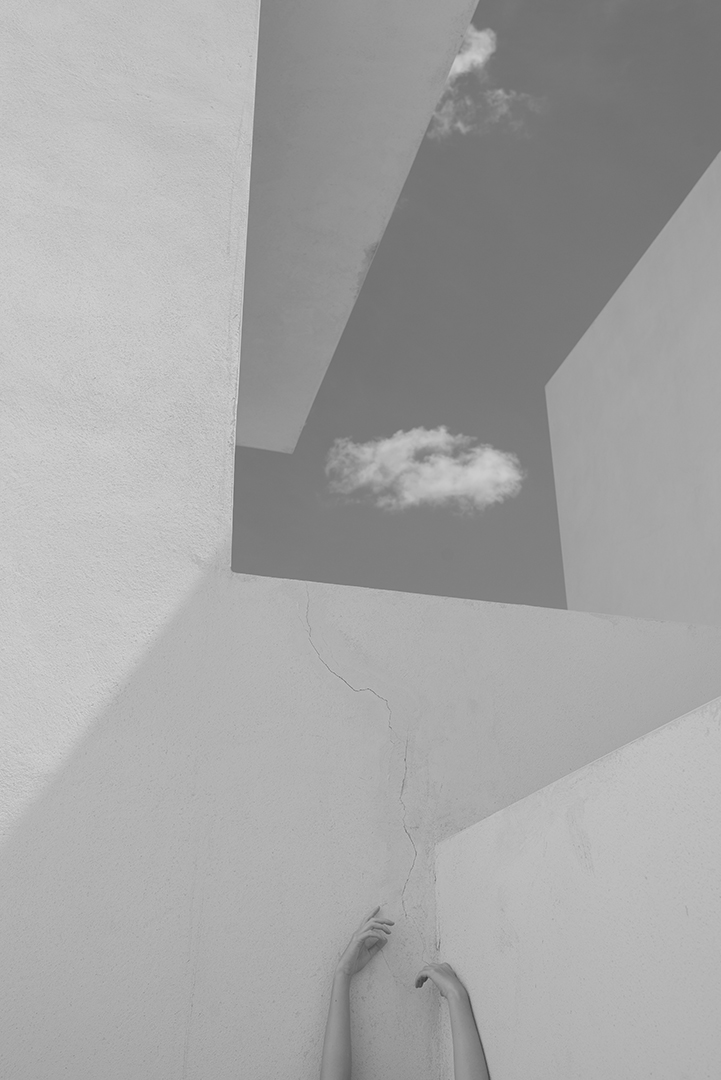

In [27]:
cv2_imshow(image)

In [17]:
image

array([[192, 201, 195, ..., 115, 115, 115],
       [193, 189, 198, ..., 115, 115, 115],
       [196, 195, 195, ..., 114, 115, 116],
       ...,
       [161, 149, 158, ..., 176, 176, 176],
       [161, 165, 166, ..., 176, 175, 174],
       [166, 165, 164, ..., 176, 176, 175]], dtype=uint8)

In [18]:
N, M = image.shape[0], image.shape[1]

block_size = (8, 8, 1)
grid_size = (int(np.ceil(N/block_size[0])),int(np.ceil(M/block_size[1])))

In [44]:
start_cpu = time.time()
result = bilateral_filtering_cpu(image, sigma_r, sigma_d)
cpu_time = time.time() - start_cpu

cv2.imwrite('res_cpu.bmp', result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


True

Результат CPU:

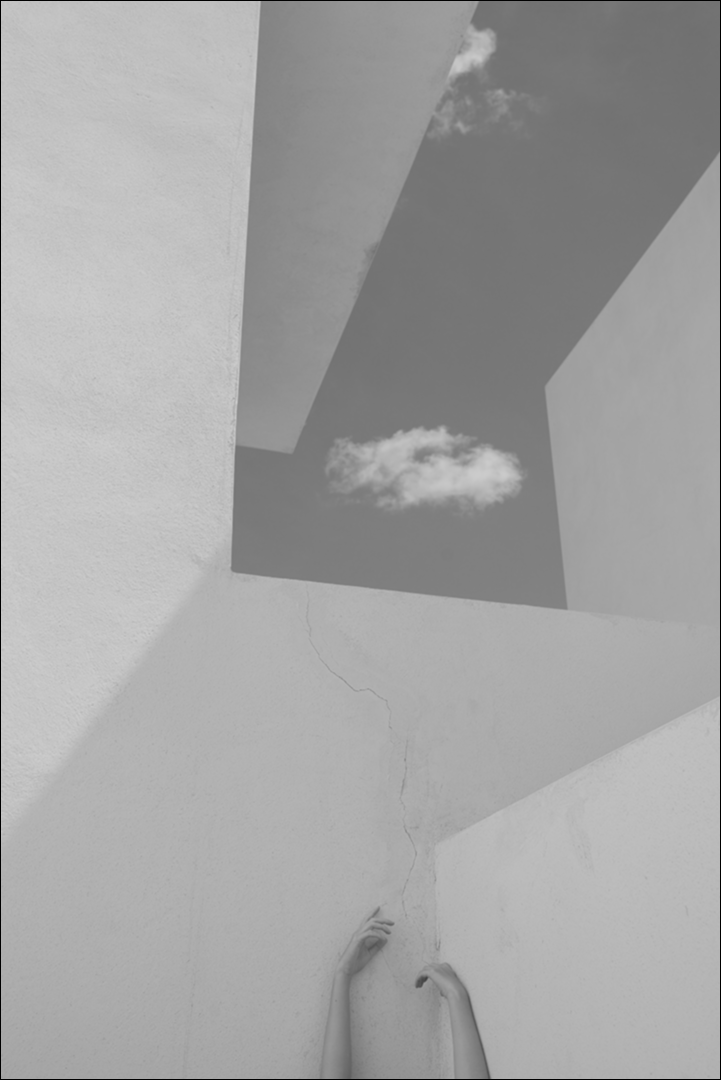

In [45]:
cv2_imshow(result)

In [48]:
result_gpu = np.zeros((N, M), dtype = np.uint32)

bilateral_filtering_gpu = mod.get_function("bilateral_filtering_gpu")

start_gpu = time.time()
tex = mod.get_texref("tex")
tex.set_filter_mode(drv.filter_mode.LINEAR)
tex.set_address_mode(0, drv.address_mode.MIRROR)
tex.set_address_mode(1, drv.address_mode.MIRROR)
drv.matrix_to_texref(image.astype(np.uint32), tex, order="C")
bilateral_filtering_gpu(drv.Out(result_gpu), np.int32(N), np.int32(M), np.float32(sigma_r), np.float32(sigma_d), block=block_size, grid=grid_size, texrefs=[tex])
drv.Context.synchronize()
time_gpu = time.time() - start_gpu

cv2.imwrite('res_gpu.bmp', result_gpu.astype(np.uint8))

True

Результат GPU:

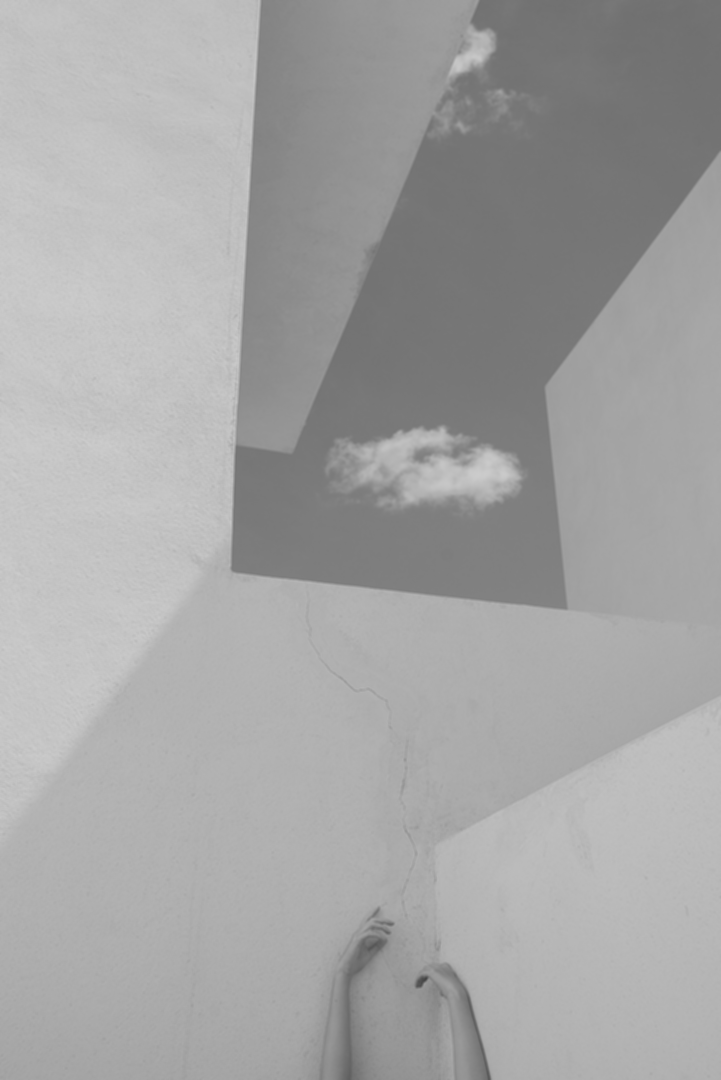

In [49]:
cv2_imshow(result_gpu)

In [50]:
result_gpu.astype(np.uint8)

array([[193, 195, 194, ..., 114, 115, 115],
       [194, 194, 194, ..., 114, 114, 115],
       [194, 194, 194, ..., 114, 114, 115],
       ...,
       [160, 159, 160, ..., 176, 175, 175],
       [161, 161, 162, ..., 175, 175, 175],
       [164, 164, 164, ..., 175, 175, 174]], dtype=uint8)

In [51]:
print('Время CPU: ', cpu_time)
print('Время GPU: ',time_gpu)
print('CPU/GPU:', cpu_time/time_gpu)

Время CPU:  80.58877968788147
Время GPU:  0.005403280258178711
CPU/GPU: 14914.78802453338
